In [68]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader

from utils import *
from models import AllCNN
from datasets import AgeDB
from unlearn import *
from metrics import *
from scipy.stats import wasserstein_distance

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("./data/agedb.csv")
df_train, df_val, df_test = df[df['split'] == 'train'], df[df['split'] == 'val'], df[df['split'] == 'test']

train_data = AgeDB(data_dir='./data', df=df_train, img_size=32, split='train')
val_data = AgeDB(data_dir='./data', df=df_val, img_size=32, split='val')
test_data = AgeDB(data_dir='./data', df=df_test, img_size=32, split='test')

In [3]:
train_loader = DataLoader(train_data, batch_size=256, shuffle=True,
                              num_workers=64, pin_memory=True, drop_last=False)
val_loader = DataLoader(val_data, batch_size=256, shuffle=False,
                            num_workers=64, pin_memory=True, drop_last=False)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False,
                             num_workers=64, pin_memory=True, drop_last=False)

## Training a model on all data

In [4]:
device = 'cuda'
model = AllCNN(num_classes=1).to(device)
epochs = 100
save_path = "../saved_models/AllCNN_AgeDB_100epochs.pt"
#history = fit_one_cycle(epochs, model, train_loader, val_loader, device = device, save_path = save_path)

In [5]:
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

## Creating separate forget and retain sets from data

In [6]:
df_train_forget = df_train[df_train['age'] <= 30]
df_val_forget = df_val[df_val['age'] <= 30]
df_test_forget = df_test[df_test['age'] <= 30]

In [7]:
train_data_forget = AgeDB(data_dir='./data', df=df_train_forget, img_size=32, split='train')
val_data_forget = AgeDB(data_dir='./data', df=df_val_forget, img_size=32, split='val')
test_data_forget = AgeDB(data_dir='./data', df=df_test_forget, img_size=32, split='test')

In [8]:
train_forget_loader = DataLoader(train_data_forget, batch_size=256, shuffle=False,
                              num_workers=64, pin_memory=True, drop_last=False)
val_forget_loader = DataLoader(val_data_forget, batch_size=256, shuffle=False,
                            num_workers=64, pin_memory=True, drop_last=False)
test_forget_loader = DataLoader(test_data_forget, batch_size=256, shuffle=False,
                             num_workers=64, pin_memory=True, drop_last=False)

In [9]:
df_train_retain = df_train[df_train['age'] > 30]
df_val_retain = df_val[df_val['age'] > 30]
df_test_retain = df_test[df_test['age'] > 30]

In [10]:
train_data_retain = AgeDB(data_dir='./data', df=df_train_retain, img_size=32, split='train')
val_data_retain = AgeDB(data_dir='./data', df=df_val_retain, img_size=32, split='val')
test_data_retain = AgeDB(data_dir='./data', df=df_test_retain, img_size=32, split='test')

In [11]:
train_retain_loader = DataLoader(train_data_retain, batch_size=256, shuffle=True,
                              num_workers=64, pin_memory=True, drop_last=False)
val_retain_loader = DataLoader(val_data_retain, batch_size=256, shuffle=False,
                            num_workers=64, pin_memory=True, drop_last=False)
test_retain_loader = DataLoader(test_data_retain, batch_size=256, shuffle=False,
                             num_workers=64, pin_memory=True, drop_last=False)

In [12]:
evaluate(model, test_retain_loader, 'cuda')

{'Loss': 9.332961082458496}

In [13]:
evaluate(model, test_forget_loader, 'cuda')

{'Loss': 12.767261505126953}

## Creating a retrained model on retain data

In [14]:
device = 'cuda'
gold_model = AllCNN(num_classes=1).to(device)
epochs = 100
save_path = "../saved_models/AllCNN_AgeDB_100epochs_0to30_Gold.pt"
#history = fit_one_cycle(epochs, gold_model, train_retain_loader, val_retain_loader, device = device, save_path = save_path)

In [16]:
gold_model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [17]:
evaluate(gold_model, test_retain_loader, 'cuda')

{'Loss': 11.382165908813477}

In [18]:
evaluate(gold_model, test_forget_loader, 'cuda')

{'Loss': 24.306758880615234}

## Unlearning using different methods

### Finetuning

In [19]:
fntn_model = AllCNN(num_classes=1).to(device)
fntn_model.load_state_dict(torch.load("../saved_models/AllCNN_AgeDB_100epochs.pt"))
epochs = 5
save_path = "saved_models/AllCNN_AgeDB_5epochs_0to30_Finetune_Forget.pt"
history = fit_one_cycle(epochs, fntn_model, train_retain_loader, val_retain_loader, lr = 0.001, device = device, save_path = save_path)

Epoch [0], last_lr: 0.00100, train_loss: 7.6173, val_loss: 9.4324
Epoch [1], last_lr: 0.00100, train_loss: 7.1440, val_loss: 9.7303
Epoch [2], last_lr: 0.00100, train_loss: 7.0587, val_loss: 9.3631
Epoch [3], last_lr: 0.00100, train_loss: 6.9867, val_loss: 9.3156
Epoch [4], last_lr: 0.00100, train_loss: 7.0971, val_loss: 9.7539


In [20]:
evaluate(fntn_model, test_retain_loader, 'cuda')

{'Loss': 9.79076862335205}

In [21]:
evaluate(fntn_model, test_forget_loader, 'cuda')

{'Loss': 14.829755783081055}

### Gaussian-Amnesiac

In [22]:
mean = df_train['age'].mean()
sd = df_train['age'].std()

random_preds = np.random.normal(loc=mean, scale=sd, size=(len(df_train[df_train['age'] <= 30]),))

amnesiac_finetune_df = df_train.copy()
amnesiac_finetune_df.loc[amnesiac_finetune_df['age'] <=30, 'age'] = random_preds

In [23]:
amnesiac_finetune_train_data = AgeDB(data_dir='./data', df=amnesiac_finetune_df, img_size=32, split='train')
amnesiac_finetune_train_loader = DataLoader(amnesiac_finetune_train_data, batch_size=256, shuffle=True,
                              num_workers=64, pin_memory=True, drop_last=False)

In [24]:
amn_model = AllCNN(num_classes=1).to(device)
amn_model.load_state_dict(torch.load("../saved_models/AllCNN_AgeDB_100epochs.pt"))
epochs = 1
save_path = "saved_models/AllCNN_AgeDB_1epoch_0to30_Amnesiac_Finetune_Forget_tmp.pt"
history = fit_one_cycle(epochs, amn_model, amnesiac_finetune_train_loader, val_retain_loader, lr = 0.001, device = device, save_path = save_path)

Epoch [0], last_lr: 0.00100, train_loss: 8.9267, val_loss: 9.9204


In [25]:
evaluate(amn_model, test_retain_loader, 'cuda')

{'Loss': 9.813302993774414}

In [26]:
evaluate(amn_model, test_forget_loader, 'cuda')

{'Loss': 17.067028045654297}

### Blindspot Unlearning

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
df_train_forget['unlearn'] = 1
df_val_forget['unlearn'] = 1
df_test_forget['unlearn'] = 1
df_train_retain['unlearn'] = 0
df_val_retain['unlearn'] = 0
df_test_retain['unlearn'] = 0

In [29]:
udf_train = pd.concat([df_train_forget, df_train_retain])
utrain_data = UAgeDB(data_dir='./data', df=udf_train, img_size=32, split='train')
utrain_loader = DataLoader(utrain_data, batch_size=256, shuffle=True,
                              num_workers=64, pin_memory=True, drop_last=False)

In [30]:
# Making the blindspot model
device = 'cuda'
bdst_model = AllCNN(num_classes=1).to(device)
epochs = 2
save_path = "saved_models/AllCNN_AgeDB_2epochs_0to30_Proxy_tmp.pt"
history = fit_one_cycle(epochs, bdst_model, train_retain_loader, val_retain_loader, device = device, save_path = save_path)

Epoch [0], last_lr: 0.01000, train_loss: 27.1785, val_loss: 121.7154
Epoch [1], last_lr: 0.01000, train_loss: 10.6321, val_loss: 19.6306


In [31]:
#Obtaining the unlearned model
bdstu_model = AllCNN(num_classes=1).to(device)
bdstu_model.load_state_dict(torch.load("../saved_models/AllCNN_AgeDB_100epochs.pt"))
epochs = 1
save_path = "saved_models/AllCNN_AgeDB_0to30_1epochs_ATBeta_50_unlearn_tmp.pt"
history = fit_one_forget_cycle(epochs, bdstu_model, bdst_model,  utrain_loader, val_loader, lr = 0.001, device = device, save_path = save_path)

Epoch [0], last_lr: 0.00100, train_loss: 10.5517, val_loss: 12.6530


In [32]:
evaluate(bdstu_model, test_retain_loader, 'cuda')

{'Loss': 9.977169036865234}

In [33]:
evaluate(bdstu_model, test_forget_loader, 'cuda')

{'Loss': 21.6317138671875}

## Comparing the models 

### Wasserstein Distance

In [60]:
gold_predict = predict(gold_model, train_forget_loader, device)
gold_outputs = torch.squeeze(gold_predict).cpu().numpy()

In [61]:
#Original Model
full_predict = predict(model, train_forget_loader, device)
full_outputs = torch.squeeze(full_predict).cpu().numpy()

wasserstein_distance(full_outputs, gold_outputs)

2.9925390871550235

In [62]:
#Finetune Model
fntn_predict = predict(fntn_model, train_forget_loader, device)
fntn_outputs = torch.squeeze(fntn_predict).cpu().numpy()

wasserstein_distance(fntn_outputs, gold_outputs)

1.6193357016625907

In [63]:
#Gaussian Amnesiac Model
amn_predict = predict(amn_model, train_forget_loader, device)
amn_outputs = torch.squeeze(amn_predict).cpu().numpy()

wasserstein_distance(amn_outputs, gold_outputs)

2.331370087042542

In [64]:
#Blindspot Unlearned Model
bdstu_predict = predict(bdstu_model, train_forget_loader, device)
bdstu_outputs = torch.squeeze(bdstu_predict).cpu().numpy()

wasserstein_distance(bdstu_outputs, gold_outputs)

1.1530339315163682

### Membership Attack Probabilities

In [39]:
sample_size = 2000
att_train_data = AgeDB(data_dir='./data', df=df_train.sample(sample_size), img_size=32, split='train')
att_val_data = AgeDB(data_dir='./data', df=df_val.sample(sample_size), img_size=32, split='val')
att_test_data = AgeDB(data_dir='./data', df=df_test.sample(sample_size), img_size=32, split='test')

In [40]:
att_train_loader = DataLoader(att_train_data, batch_size=256, shuffle=True,
                              num_workers=10, pin_memory=True, drop_last=False)
att_val_loader = DataLoader(att_val_data, batch_size=256, shuffle=False,
                            num_workers=10, pin_memory=True, drop_last=False)
att_test_loader = DataLoader(att_test_data, batch_size=256, shuffle=False,
                             num_workers=10, pin_memory=True, drop_last=False)

In [41]:
att_retain_data = AgeDB(data_dir='./data', df=df_train[df_train['age'] > 30].sample(sample_size), img_size=32, split='train')
att_forget_data = AgeDB(data_dir='./data', df=df_train[df_train['age'] <= 30].sample(sample_size), img_size=32, split='train')
att_forget_test_data = AgeDB(data_dir='./data', df=df_test[df_test['age'] <= 30].sample(min(sample_size, len(df_test[df_test['age'] <= 30]))), img_size=32, split='test')

In [42]:
att_forget_loader = DataLoader(att_forget_data, batch_size=256, shuffle=True,
                              num_workers=10, pin_memory=True, drop_last=False)
att_forget_test_loader = DataLoader(att_forget_test_data, batch_size=256, shuffle=True,
                              num_workers=10, pin_memory=True, drop_last=False)
att_retain_loader = DataLoader(att_retain_data, batch_size=256, shuffle=True,
                              num_workers=10, pin_memory=True, drop_last=False)

In [43]:
prediction_loaders = {"forget_data":att_forget_loader}

In [44]:
#Original Model
get_membership_attack_prob(att_train_loader, att_test_loader, model, prediction_loaders)

{'forget_data': 0.5925, 'train': 0.642, 'test': 0.526}

In [45]:
#Retrained Model
get_membership_attack_prob(att_train_loader, att_test_loader, gold_model, prediction_loaders)

{'forget_data': 0.3005, 'train': 0.7265, 'test': 0.5865}

In [46]:
#Finetune Model
get_membership_attack_prob(att_train_loader, att_test_loader, fntn_model, prediction_loaders)

{'forget_data': 0.4285, 'train': 0.715, 'test': 0.555}

In [47]:
#Gaussian Amnesiac Model
get_membership_attack_prob(att_train_loader, att_test_loader, amn_model, prediction_loaders)

{'forget_data': 0.4965, 'train': 0.79, 'test': 0.6195}

In [48]:
#Blindspot Unlearned Model
get_membership_attack_prob(att_train_loader, att_test_loader, bdstu_model, prediction_loaders)

{'forget_data': 0.403, 'train': 0.8135, 'test': 0.6625}

### AIN

In [49]:
#Finetune Model
ain(model, fntn_model, gold_model, train_data, val_data_retain, val_data_forget, 
                  batch_size = 256, error_range = 0.05, lr = 0.01, device = 'cuda')

0.006578947368421052

In [50]:
#Gaussian Amnesiac Model
ain(model, amn_model, gold_model, train_data, val_data_retain, val_data_forget, 
                  batch_size = 256, error_range = 0.05, lr = 0.01, device = 'cuda')

0.009615384615384616

In [51]:
#Blindspot Unlearned Model
ain(model, bdstu_model, gold_model, train_data, val_data_retain, val_data_forget, 
                  batch_size = 256, error_range = 0.05, lr = 0.01, device = 'cuda')

0.3333333333333333

### Distribution Comparison

In [65]:
labels = df_train[df_train['age'] <= 30]['age'].values

In [71]:
pred_norm_dict = {'original model':abs(full_outputs-gold_outputs)/labels,
            'ours: blindspot':abs(bdstu_outputs-gold_outputs)/labels, 
            'finetune':abs(fntn_outputs-gold_outputs)/labels,
            'g-amnesiac':abs(amn_outputs-gold_outputs)/labels}

pred_norm_df = pd.DataFrame(pred_norm_dict)

(0.0, 2.0)

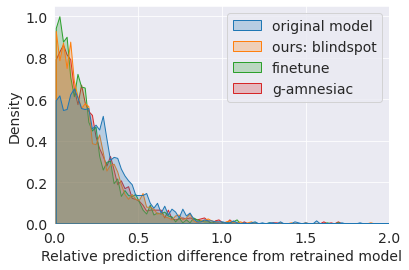

In [74]:
plt.rcParams['font.size'] = '14'

sns.set_style("darkgrid")
sns.histplot(pred_norm_df, element="poly", stat='density')
plt.xlabel("Relative prediction difference from retrained model")
plt.xlim(0,2)